In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# A Simple Compiler for a Fragment of `C`

This file shows how a simple compiler for a fragment of the programming language `C` can be implemented using `Ply`.

## Specification of the Scanner

The scanner that we implement here is similar to the scanner that we had used for our symbolic calculator.

In [2]:
import ply.lex as lex

In [3]:
tokens = [ 'NUMBER', 'ID', 'EQ', 'NE', 'LE', 'GE', 'AND', 'OR',
           'INT', 'IF', 'ELSE', 'WHILE', 'RETURN'
         ]

The token `Number` specifies a fully featured *floating point number*.

In [4]:
def t_NUMBER(t):
    r'0|[1-9][0-9]*'
    return t

Below, we define the tokens for operator symbols consisting of more than one character.

In [5]:
def t_EQ(t):
    r'=='
    return t

def t_NE(t):
    r'!='
    return t

def t_LE(t):
    r'<='
    return t

def t_GE(t):
    r'>='
    return t

def t_AND(t):
    r'&&'
    return t

def t_OR(t):
    r'\|\|'
    return t

def t_COMMENT(t):
    r'//[^\n]*'
    pass

The keywords `'int', 'if', 'else', 'while', 'return'` have to be dealt with separately as they are syntactical identical to identifiers.  The dictionary `Keywords` shown below maps every keyword to its *token type*.

In [6]:
Keywords = { 'int'   : 'INT', 
             'if'    : 'IF',
             'else'  : 'ELSE', 
             'while' : 'WHILE', 
             'return': 'RETURN'
           }

When an identifier is read, we first have to check whether the identifier is one of our keywords.  If so, we assign the corresponding token type that is stored in the dictionary `Keywords`.  Otherwise, the token type is set to `ID`.

In [7]:
def t_ID(t):
    r'[a-zA-Z][a-zA-Z0-9_]*'
    t.type = Keywords.get(t.value, 'ID')
    return t

Operators consisting of a single character do not need an associated token type.

In [8]:
literals = ['+', '-', '*', '/', '(', ')', '{', '}', ';', '=', '<', '>', '!', ',']

White space, i.e. *space characters*, *tabulators*, and *carriage returns* are ignored. 

In [9]:
t_ignore  = ' \t\r'

Syntactically, newline characters are ignored. However, we still need to keep track of them in order to know which line we are in.  This information is needed later for error messages.

In [10]:
def t_newline(t):
    r'\n'
    t.lexer.lineno += 1
    return

Given a `token`, the function `find_colum` returns the column where `token` starts.
This is possible, because `token.lexer.lexdata` stores the string that is given to the scanner and `token.lexpos` is the number of characters that precede `token`.

In [11]:
def find_column(token):
    program    = token.lexer.lexdata
    line_start = program.rfind('\n', 0, token.lexpos) + 1
    return (token.lexpos - line_start) + 1

The function `t_error` is called for any token `t` that can not be scanned by the lexer.  In this case, `t.value[0]` is the first character that can not be recognized by the scanner.

In [12]:
def t_error(t):
    column = find_column(t)
    print(f"Illegal character '{t.value[0]}' in line {t.lineno}, column {column}.")
    t.lexer.skip(1)

The next assignment is necessary to make the lexer think that the code given above is part of some file.

In [13]:
__file__ = 'main'

In [14]:
lexer = lex.lex()

In [15]:
def test_scanner(file_name):
    with open(file_name, 'r') as handle:
        program = handle.read() 
    print(program)
    lexer.input(program)
    return [t for t in lexer]

In [16]:
for t in test_scanner('Examples/Fakultaet.c'):
    print(t)

int fakultaet(int n) {
    int p;
    p = 1;
    while (n != 0) {
        p = p * n;
        n = n - 1;
    }
    return p;
}

int main() {
    int n;
    n = 1; 
    while (n <= 10) {
        println(fakultaet(n));
        n = n + 1;
    }
}

LexToken(INT,'int',1,0)
LexToken(ID,'fakultaet',1,4)
LexToken((,'(',1,13)
LexToken(INT,'int',1,14)
LexToken(ID,'n',1,18)
LexToken(),')',1,19)
LexToken({,'{',1,21)
LexToken(INT,'int',2,27)
LexToken(ID,'p',2,31)
LexToken(;,';',2,32)
LexToken(ID,'p',3,38)
LexToken(=,'=',3,40)
LexToken(NUMBER,'1',3,42)
LexToken(;,';',3,43)
LexToken(WHILE,'while',4,49)
LexToken((,'(',4,55)
LexToken(ID,'n',4,56)
LexToken(NE,'!=',4,58)
LexToken(NUMBER,'0',4,61)
LexToken(),')',4,62)
LexToken({,'{',4,64)
LexToken(ID,'p',5,74)
LexToken(=,'=',5,76)
LexToken(ID,'p',5,78)
LexToken(*,'*',5,80)
LexToken(ID,'n',5,82)
LexToken(;,';',5,83)
LexToken(ID,'n',6,93)
LexToken(=,'=',6,95)
LexToken(ID,'n',6,97)
LexToken(-,'-',6,99)
LexToken(NUMBER,'1',6,101)
LexToken(;,';',6,102)
LexToken

## Specification of the Parser

We will use the following grammar to specify the language that our compiler can translate:
```
program
    : function
    | function program

function 
    : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'

param_list 
    : 
    | INT ID 
    | INT ID ',' ne_param_list

ne_param_list
    : INT ID
    | INT ID ',' ne_param_list
    
decl_list
    : INT ID ';'
    | INT ID ';' decl_list

stmnt_list
    : stmnt
    | stmnt stmnt_list
    
stmnt 
    : '{' stmnt_list '}' 
    | ID '=' expr ';'  
    | IF '(' bool_expr ')' stmnt                 
    | IF '(' bool_expr ')' stmnt ELSE stmnt
    | WHILE '(' bool_expr ')' stmnt
    | RETURN expr ';'   
    | expr ';'       

expr: expr '+'  expr                 
    | expr '-' expr               
    | expr '*' expr               
    | expr '/' expr               
    | '(' expr ')' 
    | NUMBER
    | ID                      
    | ID '(' expr_list ')'       

expr_list
    : 
    | expr
    | expr ',' ne_expr_list

ne_expr_list
    : expr
    | expr ',' ne_expr_list

bool_expr 
    : expr '==' expr     
    | expr '!=' expr     
    | expr '<=' expr     
    | expr '>=' expr     
    | expr '<'  expr      
    | expr '>'  expr     
    | '!' bool_expr            
    | bool_expr '&&' bool_expr 
    | bool_expr '||' bool_expr  
```
We will use precedence declarations to resolve the ambiguity that is inherent in this grammar.

In [17]:
import ply.yacc as yacc

The *start variable* of our grammar is `program`.

In [18]:
start = 'program'

In [19]:
precedence = (
    ('left', 'OR'),
    ('left', 'AND'),
    ('left', '!'),
    ('nonassoc', 'EQ', 'NE', 'LE', 'GE', '<', '>'),
    ('left', '+', '-'),
    ('left', '*', '/')
)

In [20]:
def p_program_one(p):
    "program : function"
    p[0] = ('program', p[1])
    
def p_program_more(p):
    "program : function program"
    p[0] = ('program', p[1]) + p[2][1:]

In [21]:
def p_function(p):
    "function : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'"
    p[0] = ('fct', p[2], p[4], p[7], p[8])

In [22]:
def p_param_list_empty(p):
    "param_list :"
    p[0] = ('.', )
    
def p_param_list_one(p):
    "param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_param_list_more(p):
    "param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

def p_ne_param_list_one(p):
    "ne_param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_ne_param_list_more(p):
    "ne_param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [23]:
def p_decl_list_one(p):
    "decl_list : INT ID ';'"
    p[0] = ('.', p[2])

def p_decl_list_more(p):
    "decl_list : INT ID ';' decl_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [24]:
def p_stmnt_list_one(p):
    "stmnt_list : stmnt"
    p[0] = ('.', p[1])

def p_stmnt_list_more(p):
    "stmnt_list : stmnt stmnt_list"
    p[0] = ('.', p[1]) + p[2][1:]

In [25]:
def p_stmnt_block(p):
    "stmnt : '{' stmnt_list '}'"
    p[0] = p[2]
    
def p_stmnt_assign(p):
    "stmnt : ID '=' expr ';'"
    p[0] = ('=', p[1], p[3])
    
def p_stmnt_if(p):
    "stmnt : IF '(' bool_expr ')' stmnt"
    p[0] = ('if', p[3], p[5])   
    
def p_stmnt_if_else(p):
    "stmnt : IF '(' bool_expr ')' stmnt ELSE stmnt"
    p[0] = ('if-else', p[3], p[5], p[7])
    
def p_stmnt_while(p):
    "stmnt : WHILE '(' bool_expr ')' stmnt"
    p[0] = ('while', p[3], p[5])
    
def p_stmnt_return(p):
    "stmnt : RETURN expr ';'"
    p[0] = ('return', p[2])
    
def p_stmnt_expr(p):
    "stmnt : expr ';'"
    p[0] = p[1]

In [26]:
def p_bool_expr_eq(p):
    "bool_expr : expr EQ expr"
    p[0] = ('==', p[1], p[3])

def p_bool_expr_ne(p):
    "bool_expr : expr NE expr"
    p[0] = ('!=', p[1], p[3])

def p_bool_expr_le(p):
    "bool_expr : expr LE expr"
    p[0] = ('<=', p[1], p[3])
    
def p_bool_expr_ge(p):
    "bool_expr : expr GE expr"
    p[0] = ('>=', p[1], p[3])
    
def p_bool_expr_lt(p):
    "bool_expr : expr '<' expr"
    p[0] = ('<', p[1], p[3])

def p_bool_expr_gt(p):
    "bool_expr : expr '>' expr"
    p[0] = ('>', p[1], p[3])
    
def p_bool_expr_neg(p):
    "bool_expr : '!' expr"
    p[0] = ('!', p[2])
    
def p_bool_expr_and(p):
    "bool_expr : expr AND expr"
    p[0] = ('&&', p[1], p[3])
    
def p_bool_expr_or(p):
    "bool_expr : expr OR expr"
    p[0] = ('||', p[1], p[3])

In [27]:
def p_expr_plus(p):
    "expr : expr '+' expr"
    p[0] = ('+', p[1], p[3])
    
def p_expr_minus(p):
    "expr : expr '-' expr"
    p[0] = ('-', p[1], p[3])
    
def p_expr_times(p):
    "expr : expr '*' expr"
    p[0] = ('*', p[1], p[3])
    
def p_expr_divide(p):
    "expr : expr '/' expr"
    p[0] = ('/', p[1], p[3])
    
def p_expr_group(p):
    "expr : '(' expr ')'"
    p[0] = p[2]

def p_expr_number(p):
    "expr : NUMBER"
    p[0] = ('Number', p[1])

def p_expr_id(p):
    "expr : ID"
    p[0] = p[1]
    
def p_expr_fct_call(p):
    "expr : ID '(' expr_list ')'"
    p[0] = ('call', p[1]) + p[3][1:]

In [28]:
def p_expr_list_empty(p):
    "expr_list :"
    p[0] = ('.',)
    
def p_expr_list_one(p):
    "expr_list : expr"
    p[0] = ('.', p[1])     

def p_expr_list_more(p):
    "expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:]     

def p_ne_expr_list_one(p):
    "ne_expr_list : expr"
    p[0] = ('.', p[1]) 
    
def p_ne_expr_list_more(p):
    "ne_expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:] 

In [29]:
def p_error(p):
    column = find_column(p)
    if p:
        print(f'Syntax error at token "{p.value}" in line {p.lineno}, column {column}.')
    else:
        print('Syntax error at end of input.')

Setting the optional argument `write_tables` to `False` **is required** to prevent an obscure bug where the parser generator tries to read an empty parse table.  We expect that there is one shift/reduce conflict due to the *dangling else* ambiguity.

In [30]:
parser = yacc.yacc(write_tables=False, debug=True)

Generating LALR tables


The file `parser.out` confirms that the shift/reduce conflict is related to the dangling else ambiguity.  The shift/reduce conflict happens in `state 78`.

In [31]:
!cat parser.out

Created by PLY version 3.11 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> program
Rule 1     bool_expr -> expr EQ expr
Rule 2     decl_list -> INT ID ;
Rule 3     expr_list -> <empty>
Rule 4     expr -> expr + expr
Rule 5     function -> INT ID ( param_list ) { decl_list stmnt_list }
Rule 6     param_list -> <empty>
Rule 7     program -> function
Rule 8     stmnt -> { stmnt_list }
Rule 9     stmnt_list -> stmnt
Rule 10    bool_expr -> expr NE expr
Rule 11    decl_list -> INT ID ; decl_list
Rule 12    expr_list -> expr
Rule 13    expr -> expr - expr
Rule 14    param_list -> INT ID
Rule 15    program -> function program
Rule 16    stmnt -> ID = expr ;
Rule 17    stmnt_list -> stmnt stmnt_list
Rule 18    bool_expr -> expr LE expr
Rule 19    expr_list -> expr , ne_expr_list
Rule 20    expr -> expr * expr
Rule 21    param_list -> INT ID , ne_param_list
Rule 22    stmnt -> IF ( bool_expr ) stmnt
Rule 23    bool_expr -> expr GE expr
Rule 24    expr -> expr / expr
Rule 25    ne_expr_l

The notebook `AST-2-Dot.ipynb` provides the function `tuple2dot`.  This function can be used to visualize the abstract syntax tree that is generated by the function `yacc.parse`.

In [32]:
%run ../ANTLR4-Python/AST-2-Dot.ipynb

In [33]:
def parse(file_name):
    lexer.lineno = 0
    with open(file_name, 'r') as handle:
        program = handle.read() 
    ast = yacc.parse(program)
    print(ast)
    return tuple2dot(ast)

In [34]:
!cat -n Examples/Fakultaet.c

     1	int fakultaet(int n) {
     2	    int p;
     3	    p = 1;
     4	    while (n != 0) {
     5	        p = p * n;
     6	        n = n - 1;
     7	    }
     8	    return p;
     9	}
    10	
    11	int main() {
    12	    int n;
    13	    n = 1; 
    14	    while (n <= 10) {
    15	        println(fakultaet(n));
    16	        n = n + 1;
    17	    }
    18	}


('program', ('fct', 'fakultaet', ('.', 'n'), ('.', 'p'), ('.', ('=', 'p', ('Number', '1')), ('while', ('!=', 'n', ('Number', '0')), ('.', ('=', 'p', ('*', 'p', 'n')), ('=', 'n', ('-', 'n', ('Number', '1'))))), ('return', 'p'))), ('fct', 'main', ('.',), ('.', 'n'), ('.', ('=', 'n', ('Number', '1')), ('while', ('<=', 'n', ('Number', '10')), ('.', ('call', 'println', ('call', 'fakultaet', 'n')), ('=', 'n', ('+', 'n', ('Number', '1'))))))))


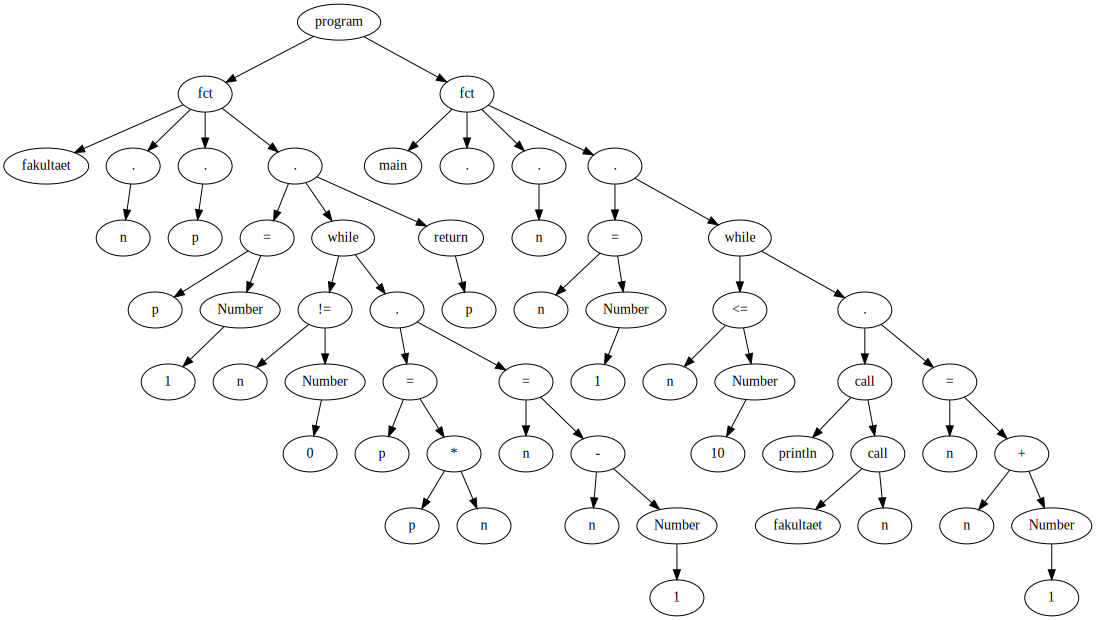

In [35]:
parse('Examples/Fakultaet.c')

In [36]:
def indent(s):
    return ' ' * 8 + s

In [37]:
def create_list(t):
    _, *L = t
    return L

The method `compile(expr, st)` takes two arguments:
- `expr` is an *abstract syntax tree* that represents an expression.  
  This abstract syntax tree is in turn represented as a nested tuple.  
- `st` is short for *symbol table*.  This is a dictionary that maps variable
  names to natural numbers.  Given a variable `x`, the number `st[x]` specifies
  the location where the variable `x` is stored on the stack with respect to the 
  local stack frame.
- `class_name` is the name of the class that is to be generated.

The function returns a pair of the form `(cmds, size)`.
- `cmds` is a list of assembler commands,
- `size` is the maximum size of the stack that is needed. 

In [38]:
def compile_expr(expr, st, class_name):
    if isinstance(expr, str):
        number = st[expr]
        Cmd    = indent(f'iload {number}')
        return [Cmd], 1
    elif expr[0] == 'Number':
        _, n = expr
        Cmd  = indent(f'ldc {n}')
        return [Cmd], 1
    elif expr[0] == '+':
        _, lhs, rhs = expr
        L1, sz1 = compile_expr(lhs, st, class_name)
        L2, sz2 = compile_expr(rhs, st, class_name)
        Cmd     = indent('iadd')
        return L1 + L2 + [Cmd], max(sz1, 1 + sz2)
    elif expr[0] == '-':
        _, lhs, rhs = expr
        L1, sz1 = compile_expr(lhs, st, class_name)
        L2, sz2 = compile_expr(rhs, st, class_name)
        Cmd     = indent('isub')
        return L1 + L2 + [Cmd], max(sz1, 1 + sz2)
    elif expr[0] == '*':
        _, lhs, rhs = expr
        L1, sz1 = compile_expr(lhs, st, class_name)
        L2, sz2 = compile_expr(rhs, st, class_name)
        Cmd     = indent('imul')
        return L1 + L2 + [Cmd], max(sz1, 1 + sz2)
    elif expr[0] == '/':
        _, lhs, rhs = expr
        L1, sz1 = compile_expr(lhs, st, class_name)
        L2, sz2 = compile_expr(rhs, st, class_name)
        Cmd     = indent('idiv')
        return L1 + L2 + [Cmd], max(sz1, 1 + sz2)
    elif expr[0] == 'call' and expr[1] == 'println':
        _, _, *args = expr
        CmdLst    = [indent('getstatic java/lang/System/out Ljava/io/PrintStream;')]
        stck_size = 0
        cnt       = 0
        for arg in args:
            L, sz_arg = compile_expr(arg, st, class_name)
            stck_size = max(stck_size, cnt + sz_arg)
            CmdLst   += L
            cnt      += 1
        CmdLst += [indent(f'invokevirtual java/io/PrintStream/println({"I"*cnt})V')]
        CmdLst += [indent('bipush 42')]
        return CmdLst, stck_size + 1
    elif expr[0] == 'call' and expr[1] != 'println':
        _, f, *args = expr
        CmdLst    = []
        stck_size = 0
        cnt       = 0
        for arg in args:
            L, sz_arg = compile_expr(arg, st, class_name)
            stck_size = max(stck_size, cnt + sz_arg)
            CmdLst   += L
            cnt      += 1
        CmdLst += [indent(f'invokestatic {class_name}/{f}({"I"*cnt})I')]
        return CmdLst, stck_size
    else:
        assert False, f'Error in compile_expr({expr}, {st}, {class_name})'

expr = ('call', 'println', 'x', ('call', 'sum', ('+', 'x', ('*', 'y', ('Number','2')))))
st   = { 'x': 0, 'y': 1}
compile_expr(expr, st, 'Sum')

In [39]:
label_counter = 0

In [40]:
def new_label():
    global label_counter
    label_counter += 1
    return 'l' + str(label_counter)

In [41]:
def compile_bool(expr, st, class_name):
    if expr[0] == '==':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmpeq ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '!=':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmpne ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '<=':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmple ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '<':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmplt ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '>=':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmpge ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '>':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        true_label = new_label()
        next_label = new_label()
        CmdLst     = L1 + L2
        CmdLst    += [indent('if_icmpgt ' + true_label)]
        CmdLst    += [indent('bipush 0')]
        CmdLst    += [indent('goto ' + next_label)]
        CmdLst    += [' ' * 4 + true_label + ':']
        CmdLst    += [indent('bipush 1')]
        CmdLst    += [' ' * 4 + next_label + ':']
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '&&':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        CmdLst     = L1 + L2 + [indent('iand')]
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '||':
        _, lhs, rhs = expr
        L1, sz1    = compile_expr(lhs, st, class_name)
        L2, sz2    = compile_expr(rhs, st, class_name)
        CmdLst     = L1 + L2 + [indent('ior')]
        return CmdLst, max(sz1, 1 + sz2)
    elif expr[0] == '!':
        _, arg = expr
        L, sz  = compile_expr(arg, st, class_name)
        CmdLst = [indent('bipush 1')] + L + [indent('isub')]
        return CmdLst, max(sz1, sz + 1)
    else:
        assert False, f'Error in compile_bool({expr}, {st}, {class_name})'

expr = ('==', 'x', ('Number', '0'))
st   = { 'x': 0, 'y': 1}
compile_bool(expr, st, 'Sum')

In [42]:
def compile_stmnt(stmnt, st, class_name):
    if stmnt[0] == '=':
        _, var, expr = stmnt
        CmdLst, sz = compile_expr(expr, st, class_name)
        CmdLst    += [indent(f'istore {st[var]}')]
        return CmdLst, sz
    elif stmnt[0] == 'if':
        _, expr, sub_stmnt = stmnt
        L1, sz1    = compile_bool(expr, st, class_name)
        L2, sz2    = compile_stmnt(sub_stmnt, st, class_name)
        else_label = new_label()
        lbl_stmnt  = ' ' * 4 + else_label + ':'
        CmdLst = L1 + [indent(f'ifeq {else_label}')] + L2 + [lbl_stmnt]
        return CmdLst, max(sz1, sz2)
    elif stmnt[0] == 'if-else':
        _, expr, then_stmnt, else_stmnt = stmnt
        L1, sz1    = compile_bool(expr, st, class_name)
        L2, sz2    = compile_stmnt(then_stmnt, st, class_name)
        L3, sz3    = compile_stmnt(else_stmnt, st, class_name)        
        else_label = new_label()
        next_label = new_label()
        if_stmnt   = indent(f'ifeq {else_label}')
        else_stmnt = ' ' * 4 + else_label + ':'
        next_stmnt = ' ' * 4 + next_label + ':'
        goto_stmnt = indent(f'goto {next_label}')
        CmdLst = L1 + [if_stmnt] + L2 + [goto_stmnt, else_stmnt] + L3 + [next_stmnt]
        return CmdLst, max(sz1, sz2, sz3)
    elif stmnt[0] == 'while':
        _, expr, body_stmnt = stmnt
        L1, sz1    = compile_bool(expr, st, class_name)
        L2, sz2    = compile_stmnt(body_stmnt, st, class_name)
        loop_label = new_label()
        next_label = new_label()
        if_stmnt   = indent(f'ifeq {next_label}')
        loop_stmnt = ' ' * 4 + loop_label + ':'        
        next_stmnt = ' ' * 4 + next_label + ':'
        goto_stmnt = indent(f'goto {loop_label}')
        CmdLst = [loop_stmnt] + L1 + [if_stmnt] + L2 + [goto_stmnt, next_stmnt]
        return CmdLst, max(sz1, sz2)
    elif stmnt[0] == 'return':
        _, expr = stmnt
        CmdLst, sz = compile_expr(expr, st, class_name)
        CmdLst    += [indent('ireturn')]
        return CmdLst, sz
    elif stmnt[0] == '.':
        _, *stmnt_lst = stmnt 
        CmdLst = []
        size   = 0
        for s in stmnt_lst:
            L, sz = compile_stmnt(s, st, class_name)
            CmdLst += L
            size   = max(size, sz)
        return CmdLst, size
    else: # it must be an expression statement
        CmdLst, sz = compile_expr(stmnt, st, class_name)
        CmdLst += [indent('pop')]
        return CmdLst, sz

stmnt = ('if', ('==', ('/', 'x', 'y'), ('Number', '0')), ('=', 'x', 'y'))
compile_stmnt(stmnt, st, 'Sum')

stmnt = ('if-else', ('<', 'x', 'y'), ('=', 'x', 'y'), ('=', 'y', 'x'))
compile_stmnt(stmnt, st, 'Sum')

stmnt = ('while', ('<', 'x', 'y'), ('=', 'x', ('+', 'x', ('Number', '1'))))
compile_stmnt(stmnt, st, 'Sum')

stmnt = ('.', ('=', 'x', 'y'), ('.', ('=', 'x', ('Number', '1')), ('=', 'y', 'x')))
compile_stmnt(stmnt, st, 'Sum')

In [43]:
def compile_fct(fct_def, class_name):
    _, name, parameters, variables, stmnts = fct_def
    parameters = create_list(parameters)
    variables  = create_list(variables)
    stmnts     = create_list(stmnts)
    m   = len(parameters)
    n   = len(variables)
    st  = {}
    cnt = 0
    for var in parameters:
        st[var] = cnt
        cnt    += 1
    for var in variables:
        st[var] = cnt
        cnt    += 1
    CmdLst = []
    size   = 0
    for stmnt in stmnts:
        L, sz = compile_stmnt(stmnt, st, class_name)
        CmdLst += L
        size = max(size, sz)
    limit_locals = f'.limit locals {m+n}'
    limit_stack  = f'.limit stack  {size}'
    end_method   = '.end method' 
    return_stmnt = indent('return')
    if name != 'main':
        method = f'.method public static {name}({"I"*m})I'
        CmdLst = [method, limit_locals, limit_stack] + CmdLst + [end_method]
        return CmdLst, sz
    else:
        method = '.method public static main([Ljava/lang/String;)V'
        CmdLst = [method, limit_locals, limit_stack] + CmdLst + [return_stmnt, end_method]
        return CmdLst, sz

f = ('fct', 'sum', ('.', 'x'), ('.', 'y', 'z'), ('.', ('return', 'x')))
compile_fct(f, 'Sum')

In [44]:
import os

In [45]:
def compile_program(file_name):
    global label_counter
    label_counter = 0
    directory = os.path.dirname(file_name)
    base      = os.path.basename(file_name)
    base      = base[:-2]
    with open(file_name, 'r') as handle:
        program = handle.read() 
    ast = yacc.parse(program)
    _, *fct_lst = ast
    CmdLst, _ = compile_fct(fct_lst[-1], base)
    CmdLst   += ['\n']
    for fct in fct_lst[:-1]:
        L, _ = compile_fct(fct, base)
        CmdLst += L
        CmdLst += ['\n']
    with open(directory + '/' + base + '.jas', 'w') as handle:
        handle.write('.class public ' + base + '\n');
        handle.write('.super java/lang/Object\n\n');
        handle.write('.method public <init>()V\n');
        handle.write('    aload 0\n');
        handle.write('    invokenonvirtual java/lang/Object/<init>()V\n');
        handle.write('    return\n');
        handle.write('.end method\n\n');
        for cmd in CmdLst:
            handle.write(cmd + '\n')

In [46]:
compile_program('Examples/Fakultaet.c')

In [47]:
!cat 'Examples/Fakultaet.jas'

.class public Fakultaet
.super java/lang/Object

.method public <init>()V
    aload 0
    invokenonvirtual java/lang/Object/<init>()V
    return
.end method

.method public static main([Ljava/lang/String;)V
.limit locals 1
.limit stack  2
        ldc 1
        istore 0
    l3:
        iload 0
        ldc 10
        if_icmple l1
        bipush 0
        goto l2
    l1:
        bipush 1
    l2:
        ifeq l4
        getstatic java/lang/System/out Ljava/io/PrintStream;
        iload 0
        invokestatic Fakultaet/fakultaet(I)I
        invokevirtual java/io/PrintStream/println(I)V
        bipush 42
        pop
        iload 0
        ldc 1
        iadd
        istore 0
        goto l3
    l4:
        return
.end method


.method public static fakultaet(I)I
.limit locals 2
.limit stack  2
        ldc 1
        istore 1
    l7:
        iload 0
        ldc 0
        if_icmpne l5
        bipush 0
        goto l6
    l5:
        bipush 1
    l6:
        ifeq l8
        iload 1
        iload